# Week 3

In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal
from utils.segbackground import NMS, background_crop
# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import ml_metrics as metrics

In [2]:
def readimg (path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# Load Data

In [3]:
# Load Data
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")

qsd2_w1, qsd2_w1_files = data_manager.load_data(folder = "./data/qsd2_w1/", extension = ".jpg", desc = "Loading qsd2_w1 Data...")
qsd1_w2, qsd1_w2_files = data_manager.load_data(folder = "./data/qsd1_w2/", extension = ".jpg", desc = "Loading qsd1_w2 Data...")
qsd2_w2, qsd2_w2_files = data_manager.load_data(folder = "./data/qsd2_w2/", extension = ".jpg", desc = "Loading qsd2_w2 Data...")

# Test W2
qst1_w2, qst2_w2_files = data_manager.load_data(folder = "./data/qst1_w2/", extension = ".jpg", desc = "Loading qst1_w2 Data...")
qst2_w2, qst2_w2_files = data_manager.load_data(folder = "./data/qst2_w2/", extension = ".jpg", desc = "Loading qst2_w2 Data...")

Loading BBDD Data...: 100%|██████████████████████████████████████████████████████████| 287/287 [00:36<00:00,  7.86it/s]


./data/BBDD/ read: 287 images


Loading qsd1_w2 Data...:  53%|█████████████████████████████▊                          | 16/30 [00:00<00:00, 115.42it/s]

./data/qsd2_w1/ read: 30 images


Loading qsd2_w2 Data...:  53%|█████████████████████████████▊                          | 16/30 [00:00<00:00, 145.84it/s]

./data/qsd1_w2/ read: 30 images


Loading qsd2_w2 Data...: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.11it/s]


./data/qsd2_w2/ read: 30 images


Loading qst1_w2 Data...: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.89it/s]


./data/qst1_w2/ read: 30 images


Loading qst2_w2 Data...: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.15it/s]


./data/qst2_w2/ read: 30 images


This week we use mainly:
- QSD1-W2: cropped images with text
- QSD2-W2: images with multiple images 

In [4]:
qsd2_w1_files[:5]

('./data/qsd2_w1/00000.jpg',
 './data/qsd2_w1/00001.jpg',
 './data/qsd2_w1/00002.jpg',
 './data/qsd2_w1/00003.jpg',
 './data/qsd2_w1/00004.jpg')

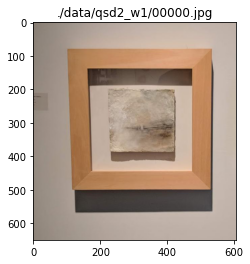

In [5]:
for img, filename in zip(qsd2_w1, qsd2_w1_files):
    plt.imshow(img)
    plt.title(filename)
    break # show only 1 image

## Step 1) Crop, background removal and obtain the pictures.

In [6]:
DO_BKGCROP = True

In [7]:
if DO_BKGCROP:
    qsd2_w1, qsd2_w1_files = background_crop (files= qsd2_w1_files, gt_masks= True, save_masks = False, plot_results=False)
    qsd2_w2, qsd2_w2_files = background_crop (files= qsd2_w2_files, gt_masks= True, save_masks = False, plot_results=False)


>> Mean IOU Score:  0.8230768956885804

>> Mean IOU Score:  0.7544650044565612


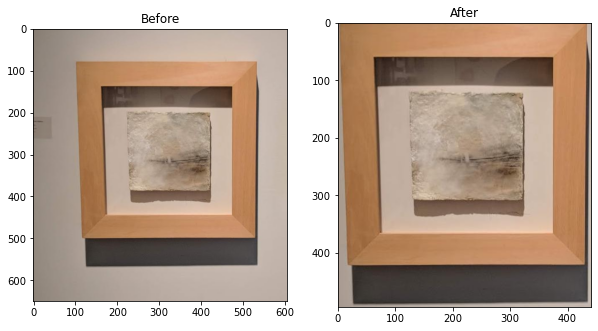

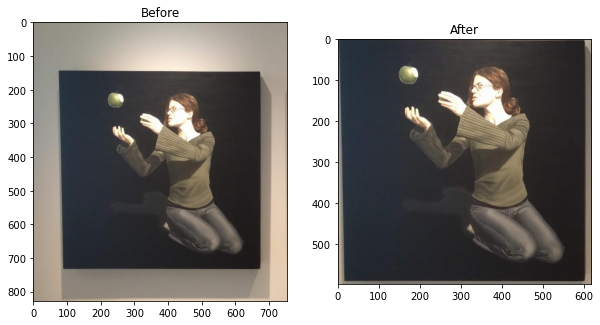

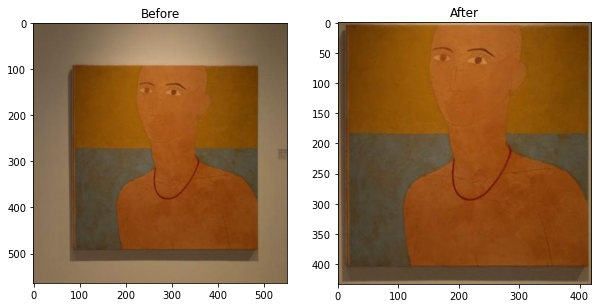

In [8]:
for img, filename in zip(qsd2_w1[:3], qsd2_w1_files[:3]):
    base = readimg (filename)
    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Before")
    axarr[1].imshow(img)
    axarr[1].title.set_text("After")
    plt.show()

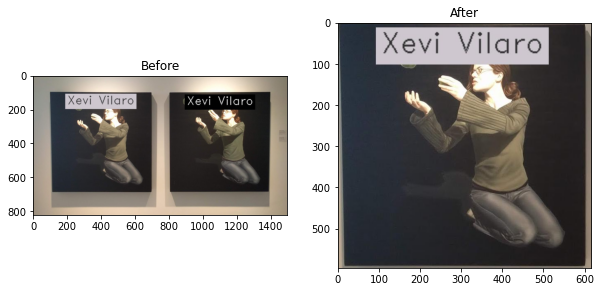

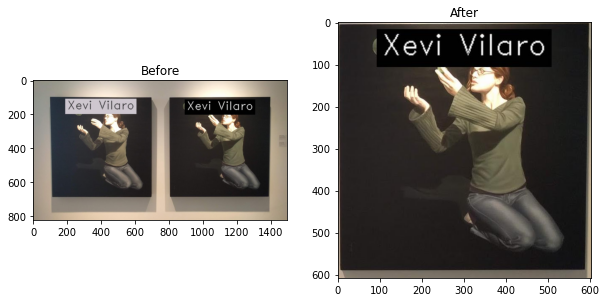

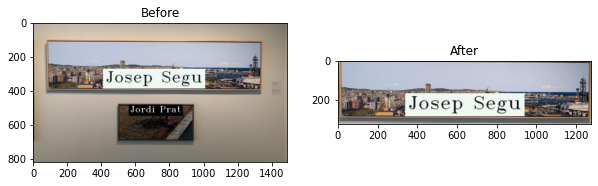

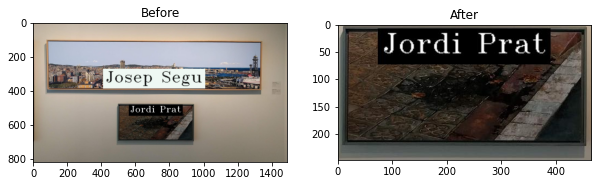

In [9]:
for img, filename in zip(qsd2_w2[:4], qsd2_w2_files[:4]):
    base = readimg (filename)
    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Before")
    axarr[1].imshow(img)
    axarr[1].title.set_text("After")
    plt.show()

## Step 2) Text Removal using crops

In [10]:
DO_TEXT_REMOVAL = True

In [12]:
#Method to remove text from the image with a rectangle 0 mask
if DO_TEXT_REMOVAL:
    new_qsd1_w2, _ = text_removal(qsd1_w2,num_images= 1,method='better', desc = 'Removing text of images') 
    qsd2_w2, _ = text_removal(qsd2_w2,num_images= 1,method='better', desc = 'Removing text of images') 

Removing text of images: 100%|█████████████████████████████████████████████████████████| 51/51 [01:23<00:00,  1.64s/it]


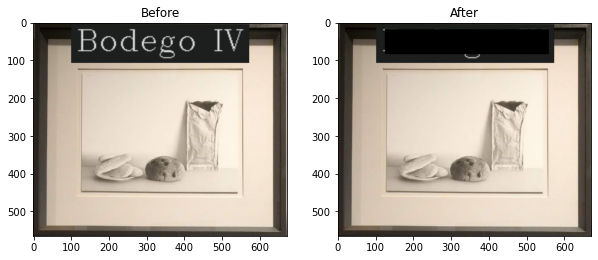

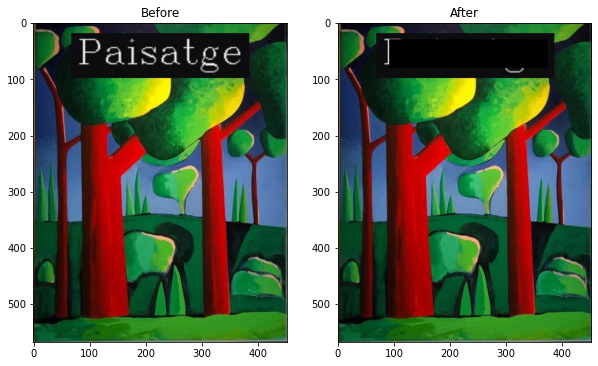

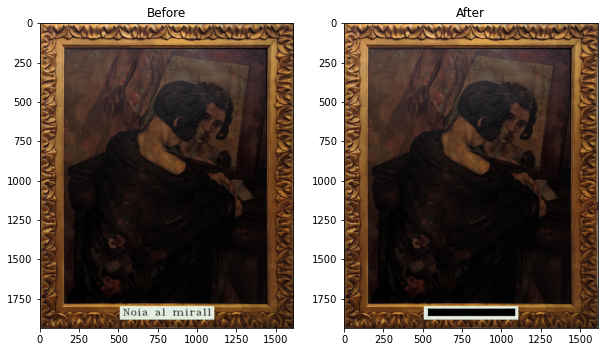

In [13]:
for img, filename in zip(new_qsd1_w2[:3], qsd1_w2_files[:3]):
    base = readimg (filename)
    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Before")
    axarr[1].imshow(img)
    axarr[1].title.set_text("After")
    plt.show()

In [ ]:
for img, filename in zip(qsd2_w2[:4], qsd2_w2_files[:4]):
    base = readimg (filename)
    
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(base)
    axarr[0].title.set_text("Before")
    axarr[1].imshow(img)
    axarr[1].title.set_text("After")
    plt.show()

## Step 3) Feature extraction

In [ ]:
NBINS = 16
NCOLS = 8
NROWS = 8

In [ ]:
# 3D Normalized Histograms Multiresolutio/Block Images
db_feature_matrix = calculate_histograms(data = db, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc="Normalized 3D Histograms Calculation for BBDD...")

qsd2_w1_feature_matrix = calculate_histograms(data = qsd2_w1, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qsd2_w1...")
qsd1_w2_feature_matrix = calculate_histograms(data = new_qsd1_w2, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qsd1_w2...")
qsd2_w2_feature_matrix = calculate_histograms(data = qsd2_w2, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qsd2_w2...")

qst1_w2_feature_matrix = calculate_histograms(data = qst1_w2, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qst1_w2...")
qst2_w2_feature_matrix = calculate_histograms(data = qst2_w2, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qst2_w2...")

# Reduce Cardinality using PCA
#db_feature_matrix = data_manager.reduce_cardinality(data = db_feature_matrix)
#qsd2_w1_feature_matrix = data_manager.reduce_cardinality(data = qsd2_w1_feature_matrix)
#qsd1_w2_feature_matrix = data_manager.reduce_cardinality(data = qsd1_w2_feature_matrix)
#qsd2_w2_feature_matrix = data_manager.reduce_cardinality(data = qsd2_w2_feature_matrix)
#qst1_w2_feature_matrix = data_manager.reduce_cardinality(data = qst1_w2_feature_matrix)
#qst2_w2_feature_matrix = data_manager.reduce_cardinality(data = qst2_w2_feature_matrix)

In [ ]:
print (f'For each of the {qsd1_w2_feature_matrix.shape[0]} images, we have a {qsd1_w2_feature_matrix.shape[1]} dimensional descriptor')

In [ ]:
# Similarity
sim = Similarity()
qs2_w1_similarities  = sim.compute_similarities(qs = qsd2_w1_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd2_w1 similarities...", similarity = 'hellinger')
qs1_w2_similarities  = sim.compute_similarities(qs = qsd1_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd1_w2 similarities...", similarity = 'hellinger')
qs2_w2_similarities  = sim.compute_similarities(qs = qsd2_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd2_w2 similarities...", similarity = 'hellinger')
qst1_w2_similarities = sim.compute_similarities(qs = qst1_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qst1_w2 similarities...", similarity = 'hellinger')
qst2_w2_similarities = sim.compute_similarities(qs = qst2_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qst2_w2 similarities...", similarity = 'hellinger')

In [ ]:
# Get top K

K = 10

top_k_qsd2_w1 = sim.get_top_k(similarity_matrix = qs2_w1_similarities, db_files = db_files, k=K, desc="Retrieving qsd2_w1 top K similar images...")
top_k_qsd1_w2 = sim.get_top_k(similarity_matrix = qs1_w2_similarities, db_files = db_files, k=K, desc="Retrieving qsd1_w2 top K similar images...")
top_k_qsd2_w2 = sim.get_top_k(similarity_matrix = qs2_w2_similarities, db_files = db_files, k=K, desc="Retrieving qsd2_w2 top K similar images...")
top_k_qst1_w2 = sim.get_top_k(similarity_matrix = qst1_w2_similarities, db_files = db_files,k=K, desc="Retrieving qst1_w2 top K similar images...")
top_k_qst2_w2 = sim.get_top_k(similarity_matrix = qst2_w2_similarities, db_files = db_files,k=K, desc="Retrieving qst2_w2 top K similar images...")

### Validation Scores

In [ ]:
SAVE_RESULTS = False
K = 10

#QSD1-W2 (Crops+text)
# Predict and Save
predicted_results = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week2/QST1/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
#predicted_results = data_manager.save_results_2(results = top_k_qsd2_w1, path = "./week2/QST1/method1", save = SAVE_RESULTS) # FOR QS WITH 1-2 PAINTINGS
expected_results = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results)*metric),len(predicted_results)))

# QSD2-W1 (simple crops)
predicted_results = data_manager.save_results_1(results = top_k_qsd2_w1, path = "./week2/QST1/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results = pickle.load(file = open('./data/qsd2_w1/gt_corresps.pkl', "rb"))
metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results)*metric),len(predicted_results)))

# QSD2-W2 (all)
predicted_results = data_manager.save_results_1(results = top_k_qsd2_w2, path = "./week2/QST1/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results = pickle.load(file = open('./data/qsd2_w2/gt_corresps.pkl', "rb"))
metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results)*metric),len(predicted_results)))

In [ ]:
plot_image_and_similar(qsd2_w1,top_k_qsd2_w1)

# GYM (NOT FINISHED)

In [ ]:
# Define Hyperparameters

DATASETS = {'QSD1-W2':new_qsd1_w2, 'QSD2-W1':qsd2_w1 }
GT = {'./data/qsd1_w2/gt_corresps.pkl' , './data/qsd2_w1/gt_corresps.pkl'}

GRID = [(16,8,8)] # (NBINS , NCOLS , NROWS)
KS   = [1, 5,10]

In [ ]:
db_feature_matrix = calculate_histograms(data = db, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc="Normalized 3D Histograms Calculation for BBDD...")

In [ ]:
for dataset in DATASETS.keys():
    
    data = DATASETS[dataset]
    print ('Dataset:', dataset, '\timages:',len(data), '\n')
    print (20 * '---')
    #plt.imshow(data[0])
    
    for params in GRID:
        
        NBINS , NCOLS , NROWS = params
        print ('>> Parameters:', NBINS , NCOLS , NROWS)

        feature_matrix = calculate_histograms(data = data, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qsd2_w1...")
        sim = Similarity()
        similarities = sim.compute_similarities(qs = feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd2_w1 similarities...", similarity = 'hellinger')
        
        for K in KS:
            top_k = sim.get_top_k(similarity_matrix = similarities, db_files = db_files, k=K, desc="Retrieving qsd2_w1 top K similar images...")
            # Predict and Save
            predicted_results = data_manager.save_results_1(results = top_k, path = "./week2/QST1/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
            expected_results = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
            metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=K)
            print(">>> MAP@{} Score: {:.4f}% ({}/{})".format(K,metric*100,int(len(predicted_results)*metric),len(predicted_results)))
        
        print ()
        print (20 * '===')
        print ()
       
    print ()
    break